# 1. Байесовский генератор стилей

## A) Генерация стилей

In [1]:
styles = {
    'прическа': [
        'нет волос',
        'длинные в пучок',
        'длинные волнистые',
        'длинные прямые',
        'короткая волнистые',
        'короткая прямые',
        'короткая курчавые'
    ],
    'цвет волос': [
        'черный',
        'блонд',
        'каштановый',
        'пастельный розовый',
        'рыжий',
        'серебристо серый',
    ],
    'аксесуар': [
        'нет очков',
        'круглые очки',
        'солнцезащитные очки',
    ],
    'одежда': [
        'худи',
        'комбинезон',
        'футболка с круглым вырезом',
        'футболка с V-вырезом',
    ],
    'цвет одежды':[
        'черный',
        'синий',
        'серый',
        'зеленый',
        'оранжевый',
        'розовый',
        'красный',
        'белый'
    ],
}

styles_count = {
    'прическа':[
        7,
        0,
        1,
        23,
        1,
        11,
        7
    ],
    'цвет волос':[
        7,
        6,
        2,
        3,
        8,
        24,
    ],
    'аксесуар':[
        11,
        22,
        17,
    ],
    'одежда':[
        7,
        18,
        19,
        6,
    ],
    'цвет одежды': [
        4,
        5,
        6,
        8,
        6,
        8,
        7,
        6
    ],
}

In [2]:
def collect_data(styles, styles_count):
    collections = {}
    probs = {}
    eps = 1e-3
    for style in styles:
        sum_ = sum(styles_count[style]) # сумма предметов кокретного стиля
        probs[style] = {}
        smth = []
        for i, item in enumerate(styles[style]):
            smth.append(item)
            count = styles_count[style][i] # кол-во определенного предмета
            probs[style][item] = (count + eps) / (sum_ + eps) # аддитивное сглаживание
        collections[style] = smth
    return collections, probs

In [3]:
collections, probs = collect_data(styles, styles_count)

In [4]:
from itertools import product

In [5]:
all_combinations = list(product(collections["прическа"], collections["цвет волос"], collections["аксесуар"], collections["одежда"], collections["цвет одежды"]))

In [6]:
def generate_styles_with_prob(all_combinations, probs):
    n = len(all_combinations)
    i = 0
    while i < n:
        design = all_combinations[i]
        p = probs["прическа"][design[0]] * probs["цвет волос"][design[1]] * probs["аксесуар"][design[2]] * probs["одежда"][design[3]] * probs["цвет одежды"][design[4]]
        yield design, p
        i += 1
    
            

In [7]:
next(generate_styles_with_prob(all_combinations, probs))

(('нет волос', 'черный', 'нет очков', 'худи', 'черный'), 4.832673984472403e-05)

## Б) Генерирация картинок

In [8]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

In [9]:
path_imgs = glob.glob("/kaggle/input/hole-metall-outlier-detection/avatars/avatars/avataaars_*")

In [10]:
def collect_stat():
    ch_stat = {}
    for i in range(560):
        for j in range(528):
            ch_stat[(i, j)] = {k: 0 for k in range(256)}
    return ch_stat
    

In [11]:
ch0_stat = collect_stat()
ch1_stat = collect_stat()
ch2_stat = collect_stat()

In [12]:
def add_stat(ch_stat, channel=0):
    for path in path_imgs:
        img = cv2.imread(path)
        img = img[:, :, channel]
        for i in range(560):
            for j in range(528):
                value = img[i, j]
                ch_stat[(i, j)][value] += 1
    return ch_stat

In [13]:
ch0_stat = add_stat(ch0_stat, channel=0)
ch1_stat = add_stat(ch1_stat, channel=1)
ch2_stat = add_stat(ch2_stat, channel=2)

In [14]:
def convert_to_prob(ch_stat):
    eps = 1e-3
    for i in range(560):
        for j in range(528):
            counts = np.array(list(ch_stat[(i, j)].values()))
            counts = counts + eps
            prob = counts / counts.sum()
            ch_stat[(i, j)] = prob
    return ch_stat
    

In [15]:
ch0_stat = convert_to_prob(ch0_stat)
ch1_stat = convert_to_prob(ch1_stat)
ch2_stat = convert_to_prob(ch2_stat)

In [16]:
def sample_pixel(ch_stat):
    ch_pixels = np.zeros((560, 528))
    for i in range(560):
        for j in range(528):
            prob = ch_stat[(i, j)]
            ch_pixels[i, j] = np.random.choice(256, 1, p=prob)[0]
    ch_pixels = np.expand_dims(ch_pixels, axis=2)
    return ch_pixels

In [17]:
def generate_img(ch_stats):
    chunks = []
    for ch_stat in ch_stats:
        ch_stat = sample_pixel(ch_stat)
        chunks.append(ch_stat)
    img = np.concatenate(chunks, axis=2)
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

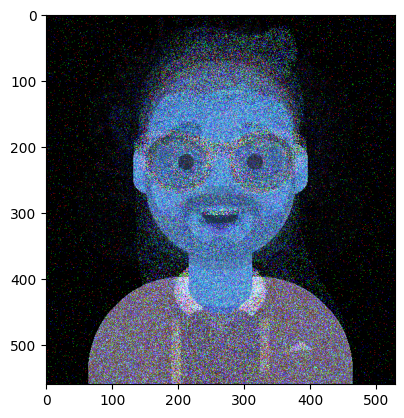

In [18]:
generate_img([ch0_stat, ch1_stat, ch2_stat])

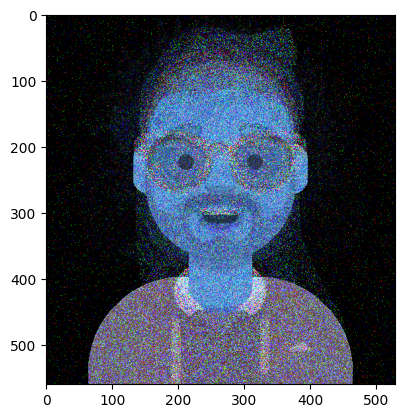

In [19]:
generate_img([ch0_stat, ch1_stat, ch2_stat])

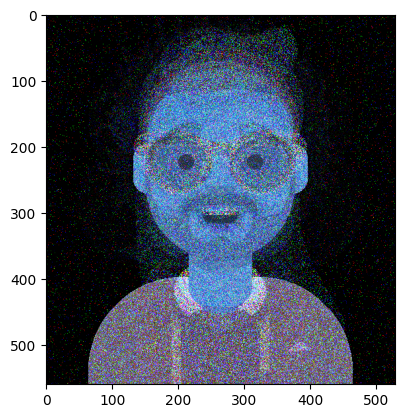

In [20]:
generate_img([ch0_stat, ch1_stat, ch2_stat])

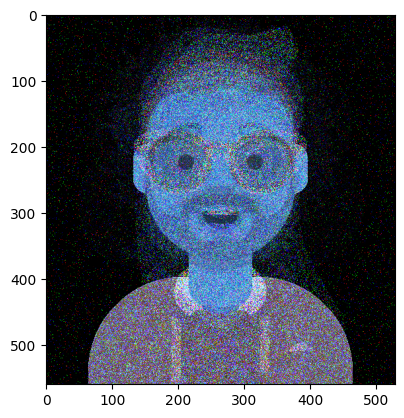

In [21]:
generate_img([ch0_stat, ch1_stat, ch2_stat])

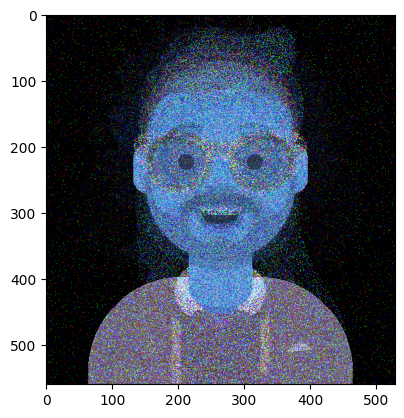

In [22]:
generate_img([ch0_stat, ch1_stat, ch2_stat])

In [23]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import os
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

In [24]:
SEED = 42

In [25]:
torch.manual_seed(SEED)
plt.rcParams['figure.dpi'] = 200

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(3*27*48, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [28]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 3*27*48)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        return z.reshape((-1, 3, 27, 48))

In [29]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(z)
        return z

#### Класс для картинок

In [30]:
class JPGDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super().__init__()
        """
        Args:
            data_dir (str): Path to the directory containing JPG files.
            transform (callable, optional): A function to apply to each image.
        """
        self.image_paths = glob.glob(data_dir + "/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        
        if self.transform:
            image = self.transform(image)
            
        return image

#### Унаследованный класс для получения и тензора картинки и ее лейбла

In [31]:
class JPGDatasetTest(JPGDataset):
    def __init__(self, data_dir, transform=None):
        super().__init__(data_dir, transform)
    
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        image_path = os.path.basename(image_path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, image_path

In [32]:
train_dir = "/kaggle/input/hole-metall-outlier-detection/dataset/dataset/train"

In [33]:
data_transform = transforms.Compose([transforms.Resize(size=(27, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])])

In [34]:
train_transform = transforms.Compose([
    data_transform,
    transforms.RandomHorizontalFlip(p=0.1)
])

In [35]:
train_dataset = JPGDataset(train_dir, transform=train_transform)

In [36]:
num_workers = 4
lat_dims = 50

In [37]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=num_workers
)


In [38]:
def train(autoencoder, data, epochs):
    loss_values = []
    opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)
    for epoch in tqdm.tqdm(range(epochs)):
        loss_epoch = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss_epoch += loss.item()
            loss.backward()
            opt.step()
        loss_epoch /= len(data)
        loss_values.append(loss_epoch)
    return loss_values

In [39]:
EPOCHS = 40

In [40]:
autoencoder = Autoencoder(lat_dims).to(device)

In [41]:
loss_values = train(autoencoder, train_dataloader, epochs=EPOCHS)

100%|██████████| 40/40 [02:56<00:00,  4.41s/it]


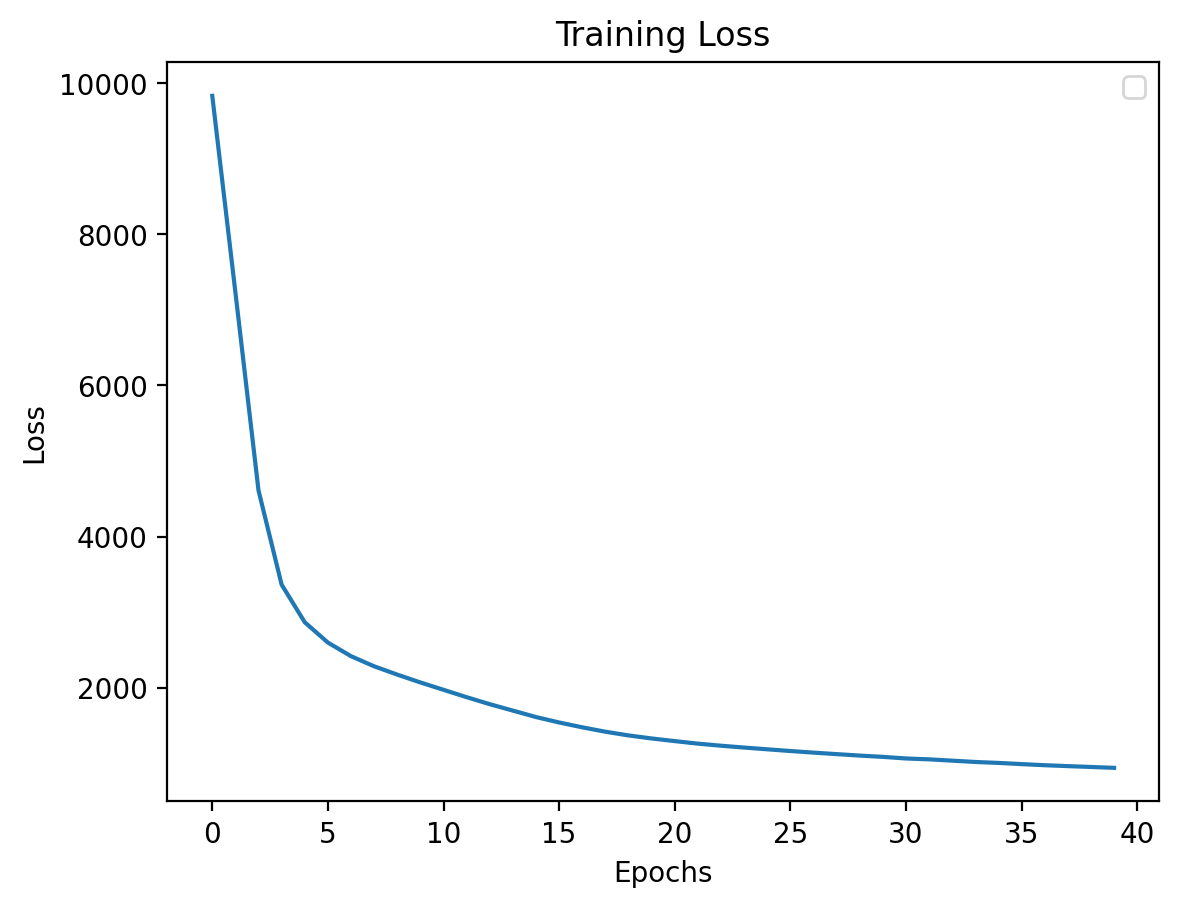

In [42]:
plt.plot(loss_values)

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
valid_dataset = JPGDataset(train_dir, transform=data_transform)

In [44]:
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

In [45]:
def validate(autoencoder, data):
    autoencoder.eval()  # Set the model to evaluation mode
    loss_values = []
    with torch.no_grad():
        for x in data:
            x = x.to(device) # GPU
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss_values.append(loss.item())
    loss_values = np.array(loss_values)
    return loss_values

#### Соберем стастистику лосса для непроливов

In [46]:
valid_loss = validate(autoencoder, valid_dataloader)

In [47]:
valid_loss.max()

81.85888671875

In [48]:
valid_loss.mean()

6.385017486190796

In [49]:
data_dir = "/kaggle/input/hole-metall-outlier-detection/dataset/dataset/proliv"

In [50]:
proliv_dataset = JPGDataset(data_dir, transform=data_transform)

In [51]:
proliv_dataloader = DataLoader(
    proliv_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

#### Соберем стастистику лосса для проливов

In [52]:
proliv_loss = validate(autoencoder, proliv_dataloader)

In [53]:
proliv_loss.min()

25.57988929748535

In [54]:
proliv_loss.mean()

50.45360549084552

#### Функция для детекции проливов на основании порога по MSE

In [55]:
def classificate(autoencoder, data, threshold):
    autoencoder.eval()
    predicts = {}
    with torch.no_grad():
        for x, file_name in data:
            x = x.to(device) # GPU
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            label = 1 if loss.item() > threshold else 0  # если лосс выше порога отмечаю как пролив
            predicts[file_name[0]] = label
            
    return predicts

In [56]:
test_dir = "/kaggle/input/hole-metall-outlier-detection/dataset/dataset/test/imgs"

In [57]:
test_dataset = JPGDatasetTest(test_dir, transform=data_transform)

In [58]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

In [59]:
predicts = classificate(autoencoder, test_dataloader, 55)

In [60]:
def parse_annotate_data():
    with open("/kaggle/input/hole-metall-outlier-detection/dataset/dataset/test/test_annotation.txt") as fi:
        lines = fi.readlines()
        
    lines = [line.strip().split(" ") for line in lines]
    ground_truth = {}
    
    for item in lines:
        file_name, label = item
        ground_truth[file_name] = int(label)
        
    return ground_truth

In [61]:
ground_truth = parse_annotate_data()

In [62]:
y_true = []
y_pred = []

for img in predicts:
    y_true.append(ground_truth[img])
    y_pred.append(predicts[img])

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
def calculate_tpr_tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)   
    return tpr, tnr

In [65]:
tpr, tnr = calculate_tpr_tnr(y_true, y_pred)

In [66]:
print(classification_report(y_true, y_pred))
tpr, tnr = calculate_tpr_tnr(y_true, y_pred)

print('#############')
print(f"True Positive Rate (TPR): {tpr}")
print(f"True Negative Rate (TNR): {tnr}")

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3665
           1       0.59      0.64      0.61       129

    accuracy                           0.97      3794
   macro avg       0.79      0.81      0.80      3794
weighted avg       0.97      0.97      0.97      3794

#############
True Positive Rate (TPR): 0.6356589147286822
True Negative Rate (TNR): 0.9844474761255116
